In [ ]:
pip install lazypredict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Perceptron
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from xgboost import XGBClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
#Reading data
df = pd.read_csv('ACME-HappinessSurvey2020.csv', header = 0)
print(df.head())
df.shape

   Y  X1  X2  X3  X4  X5  X6
0  0   3   3   3   4   2   4
1  0   3   2   3   5   4   3
2  1   5   3   3   3   3   5
3  0   5   4   3   3   3   5
4  0   5   4   3   3   3   5


(126, 7)

In [ ]:
df['Y'].value_counts ()
# The dataset is balanced.

Y
1    69
0    57
Name: count, dtype: int64

In [ ]:
print("Missing values in each column:\n", df.isnull().sum())

Missing values in each column:
 Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [ ]:
# Map Y values to categorical variables 'yes' satisfied and 'no' unsatisfied
df['Y'] = df['Y'].map({1: 'yes', 0: 'no'})

# Display the updated DataFrame to verify changes
print(df.head())

     Y  X1  X2  X3  X4  X5  X6
0   no   3   3   3   4   2   4
1   no   3   2   3   5   4   3
2  yes   5   3   3   3   3   5
3   no   5   4   3   3   3   5
4   no   5   4   3   3   3   5


In [ ]:
# Display summary statistics of the DataFrame
df .describe ()

,X1,X2,X3,X4,X5,X6
count,126.00,126.00,126.00,126.00,126.00,126.00
mean,4.33,2.53,3.31,3.75,3.65,4.25
std,0.80,1.11,1.02,0.88,1.15,0.81
min,1.00,1.00,1.00,1.00,1.00,1.00
25%,4.00,2.00,3.00,3.00,3.00,4.00
50%,5.00,3.00,3.00,4.00,4.00,4.00
75%,5.00,3.00,4.00,4.00,4.00,5.00
max,5.00,5.00,5.00,5.00,5.00,5.00


In [ ]:
satisfied_yes = df[df['Y'] == 'yes']
print(satisfied_yes.describe())

         X1    X2    X3    X4    X5    X6
count 69.00 69.00 69.00 69.00 69.00 69.00
mean   4.54  2.51  3.45  3.80  3.88  4.38
std    0.70  1.11  1.02  0.90  1.06  0.77
min    3.00  1.00  1.00  1.00  1.00  1.00
25%    4.00  2.00  3.00  3.00  3.00  4.00
50%    5.00  2.00  3.00  4.00  4.00  5.00
75%    5.00  3.00  4.00  4.00  5.00  5.00
max    5.00  5.00  5.00  5.00  5.00  5.00


In [ ]:
satisfied_no = df[df['Y'] == 'no']
print(satisfied_no.describe())

         X1    X2    X3    X4    X5    X6
count 57.00 57.00 57.00 57.00 57.00 57.00
mean   4.09  2.56  3.14  3.68  3.37  4.11
std    0.85  1.13  1.01  0.85  1.19  0.84
min    1.00  1.00  1.00  2.00  1.00  2.00
25%    4.00  2.00  3.00  3.00  3.00  3.00
50%    4.00  3.00  3.00  4.00  4.00  4.00
75%    5.00  3.00  4.00  4.00  4.00  5.00
max    5.00  5.00  5.00  5.00  5.00  5.00


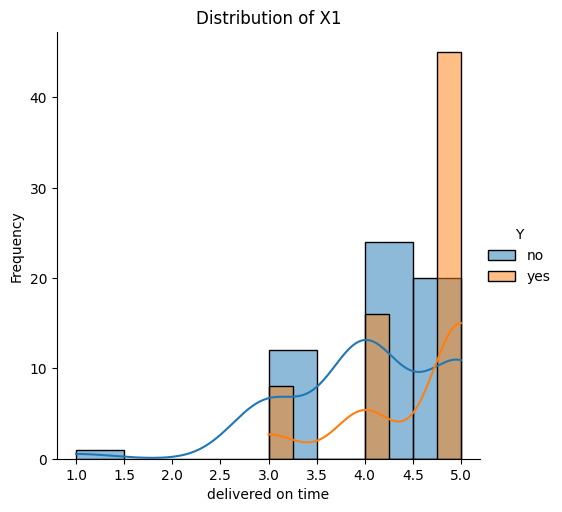

In [ ]:
sns.FacetGrid(df, hue="Y", height=5).map(sns.histplot, "X1", kde=True).add_legend()
plt.title('Distribution of X1')
plt.xlabel('delivered on time')
plt.ylabel('Frequency')
plt.show()
#It is an important factor, most of the satisfied cutomer gave 5 to delivered on time.

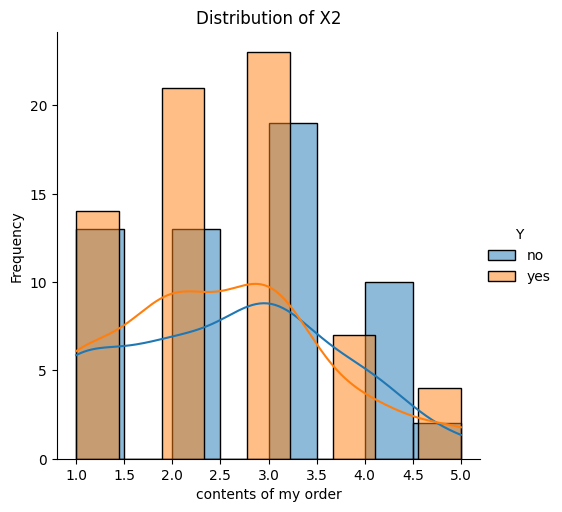

In [ ]:
sns.FacetGrid(df, hue="Y", height=5).map(sns.histplot, "X2", kde=True).add_legend()
plt.title('Distribution of X2')
plt.xlabel('contents of my order')
plt.ylabel('Frequency')
plt.show()
#there is a significant overlap between the class labels, suggesting that X2 alone is not a distinctive factor

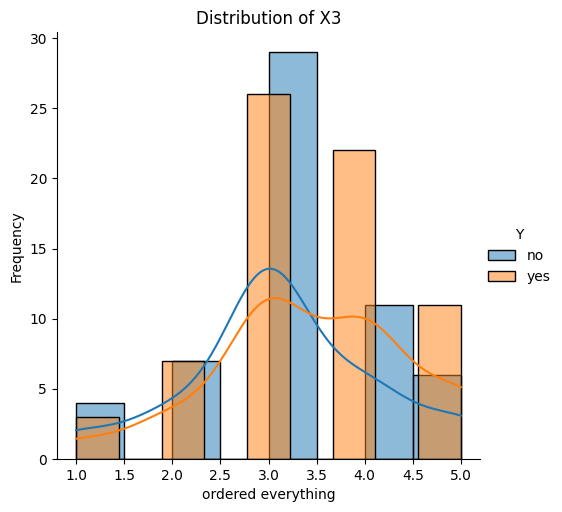

In [ ]:
sns.FacetGrid(df, hue="Y", height=5).map(sns.histplot, "X3", kde=True).add_legend()
plt.title('Distribution of X3')
plt.xlabel('ordered everything')
plt.ylabel('Frequency')
plt.show()
#there is a significant overlap between the class labels, suggesting that X3 alone is not a distinctive factor

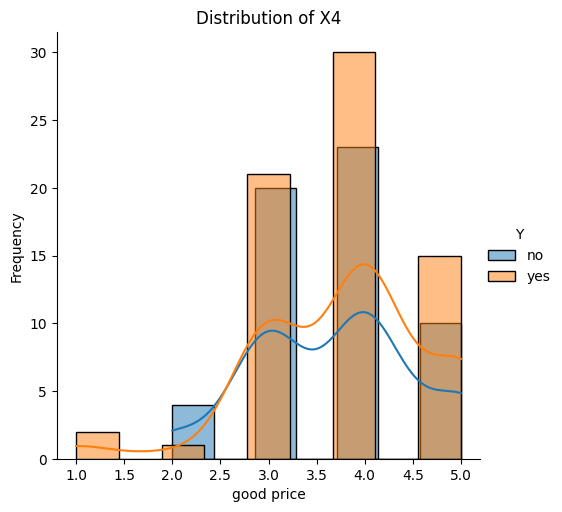

In [ ]:
sns.FacetGrid(df, hue="Y", height=5).map(sns.histplot, "X4", kde=True).add_legend()
plt.title('Distribution of X4')
plt.xlabel('good price')
plt.ylabel('Frequency')
plt.show()
#It is an important factor, most of the satisfied cutomer gave 4 and 5 to good price.

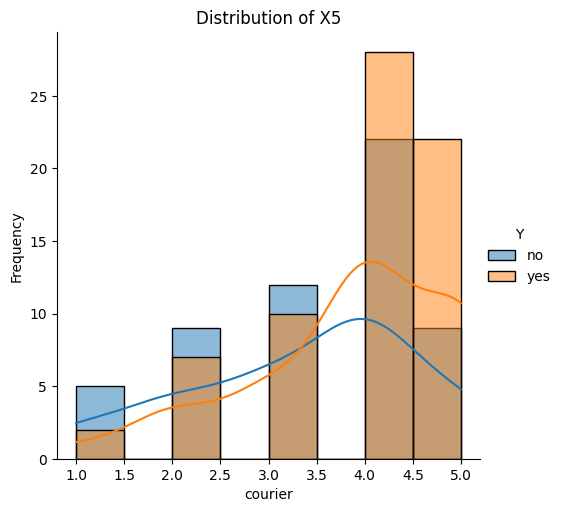

In [ ]:
sns.FacetGrid(df, hue="Y", height=5).map(sns.histplot, "X5", kde=True).add_legend()
plt.title('Distribution of X5')
plt.xlabel('courier')
plt.ylabel('Frequency')
plt.show()
#It is an important factor, most of the satisfied cutomer gave 4 and 5 to courior.

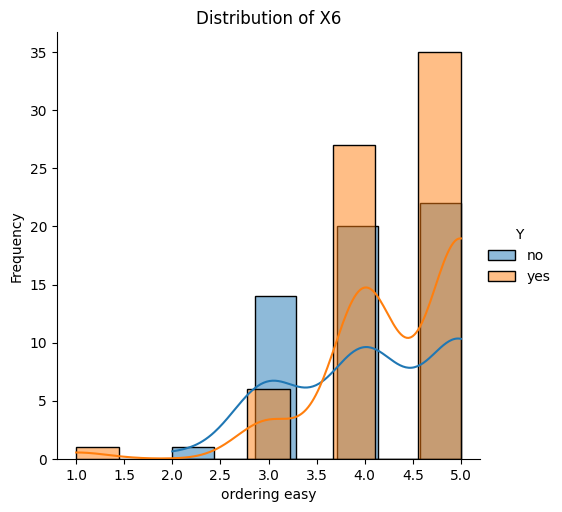

In [ ]:
sns.FacetGrid(df, hue="Y", height=5).map(sns.histplot, "X6", kde=True).add_legend()
plt.title('Distribution of X6')
plt.xlabel('ordering easy')
plt.ylabel('Frequency')
plt.show()
#It is an important factor, most of the satisfied cutomer gave 4 and 5 to ordering easy.

In [ ]:
df = pd.read_csv('ACME-HappinessSurvey2020.csv', header = 0)
print(df.head())
data=df
data.shape

   Y  X1  X2  X3  X4  X5  X6
0  0   3   3   3   4   2   4
1  0   3   2   3   5   4   3
2  1   5   3   3   3   3   5
3  0   5   4   3   3   3   5
4  0   5   4   3   3   3   5


(126, 7)

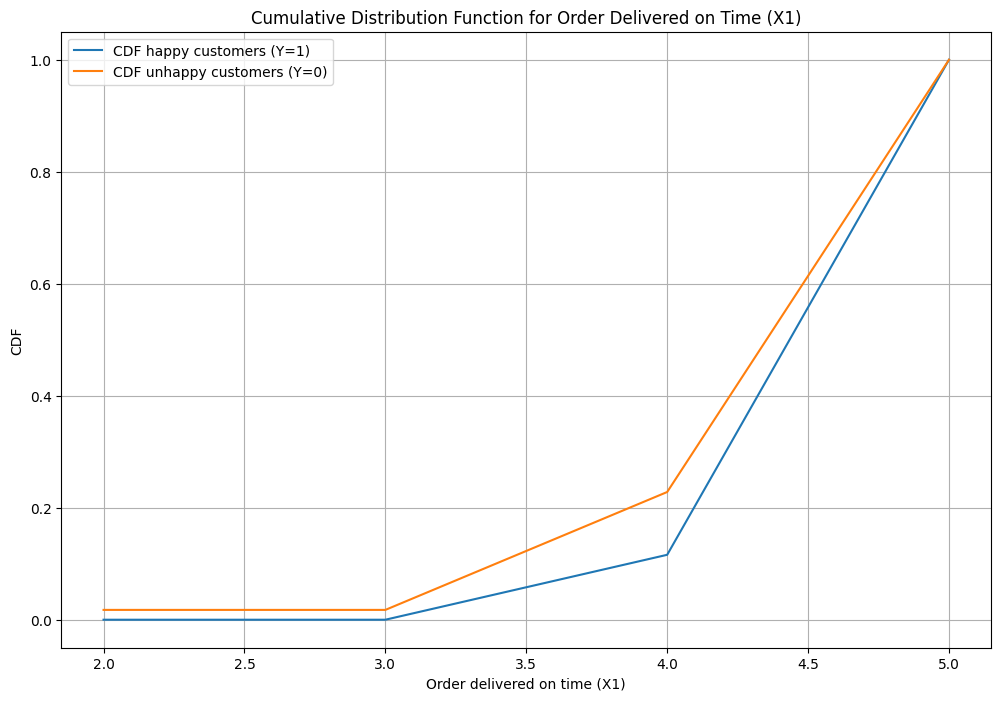

In [ ]:

# Let's update the bins and ensure they cover the range of X1 values from 1 to 5
bins = range(1, 6)  # Bins from 1 to 5 inclusive

# Calculate CDF for Y = 1 (happy)
counts_happy, bin_edges_happy = np.histogram(data[data['Y'] == 1]['X1'], bins=bins, density=True)
pdf_happy = counts_happy / sum(counts_happy)
cdf_happy = np.cumsum(pdf_happy)

# Calculate CDF for Y = 0 (unhappy)
counts_unhappy, bin_edges_unhappy = np.histogram(data[data['Y'] == 0]['X1'], bins=bins, density=True)
pdf_unhappy = counts_unhappy / sum(counts_unhappy)
cdf_unhappy = np.cumsum(pdf_unhappy)

# Plot the CDFs
plt.figure(figsize=(12, 8))

plt.plot(bin_edges_happy[1:], cdf_happy, label='CDF happy customers (Y=1)')
plt.plot(bin_edges_unhappy[1:], cdf_unhappy, label='CDF unhappy customers (Y=0)')

plt.legend()
plt.xlabel("Order delivered on time (X1)")
plt.ylabel("CDF")
plt.title('Cumulative Distribution Function for Order Delivered on Time (X1)')
plt.grid()
plt.show()

#customers with 4 or fewer X1 have about a chance of being unhappy.

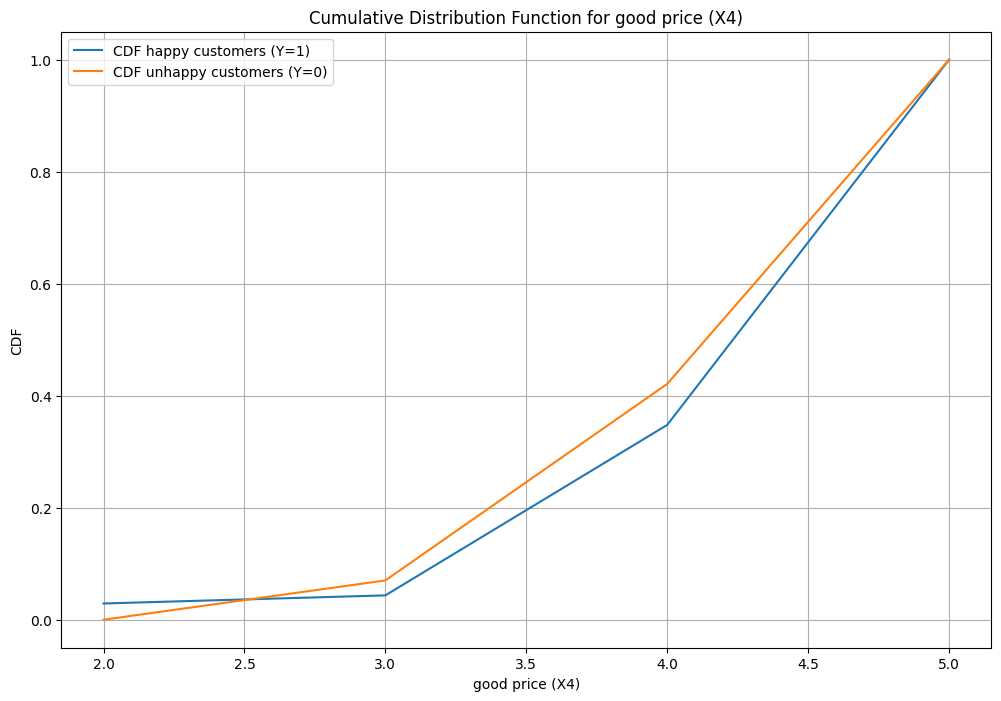

In [ ]:
# Let's update the bins and ensure they cover the range of X4 values from 1 to 5
bins = range(1, 6)  # Bins from 1 to 5 inclusive

# Calculate CDF for Y = 1 (happy)
counts_happy, bin_edges_happy = np.histogram(data[data['Y'] == 1]['X4'], bins=bins, density=True)
pdf_happy = counts_happy / sum(counts_happy)
cdf_happy = np.cumsum(pdf_happy)

# Calculate CDF for Y = 0 (unhappy)
counts_unhappy, bin_edges_unhappy = np.histogram(data[data['Y'] == 0]['X4'], bins=bins, density=True)
pdf_unhappy = counts_unhappy / sum(counts_unhappy)
cdf_unhappy = np.cumsum(pdf_unhappy)

# Plot the CDFs
plt.figure(figsize=(12, 8))

plt.plot(bin_edges_happy[1:], cdf_happy, label='CDF happy customers (Y=1)')
plt.plot(bin_edges_unhappy[1:], cdf_unhappy, label='CDF unhappy customers (Y=0)')

plt.legend()
plt.xlabel("good price (X4)")
plt.ylabel("CDF")
plt.title('Cumulative Distribution Function for good price (X4)')
plt.grid()
plt.show()

#customers with 4 or fewer X4 have about a chance of being unhappy.

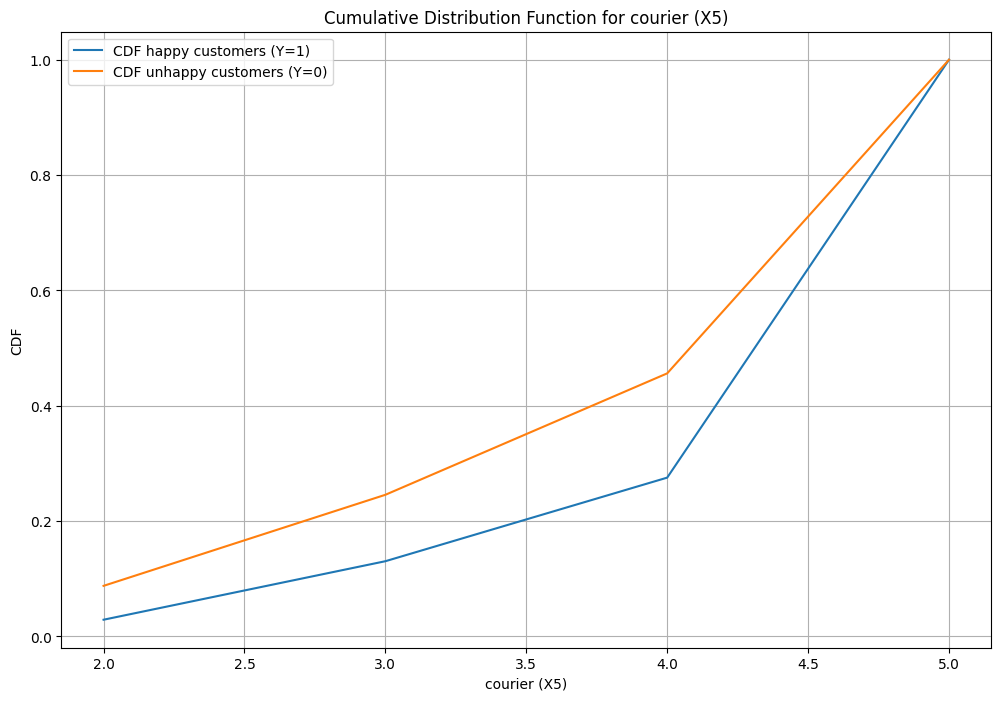

In [ ]:
# Let's update the bins and ensure they cover the range of X5 values from 1 to 5
bins = range(1, 6)  # Bins from 1 to 5 inclusive

# Calculate CDF for Y = 1 (happy)
counts_happy, bin_edges_happy = np.histogram(data[data['Y'] == 1]['X5'], bins=bins, density=True)
pdf_happy = counts_happy / sum(counts_happy)
cdf_happy = np.cumsum(pdf_happy)

# Calculate CDF for Y = 0 (unhappy)
counts_unhappy, bin_edges_unhappy = np.histogram(data[data['Y'] == 0]['X5'], bins=bins, density=True)
pdf_unhappy = counts_unhappy / sum(counts_unhappy)
cdf_unhappy = np.cumsum(pdf_unhappy)

# Plot the CDFs
plt.figure(figsize=(12, 8))

plt.plot(bin_edges_happy[1:], cdf_happy, label='CDF happy customers (Y=1)')
plt.plot(bin_edges_unhappy[1:], cdf_unhappy, label='CDF unhappy customers (Y=0)')

plt.legend()
plt.xlabel("courier (X5)")
plt.ylabel("CDF")
plt.title('Cumulative Distribution Function for courier (X5)')
plt.grid()
plt.show()

#customers with 4 or fewer X5 have about a chance of being unhappy.

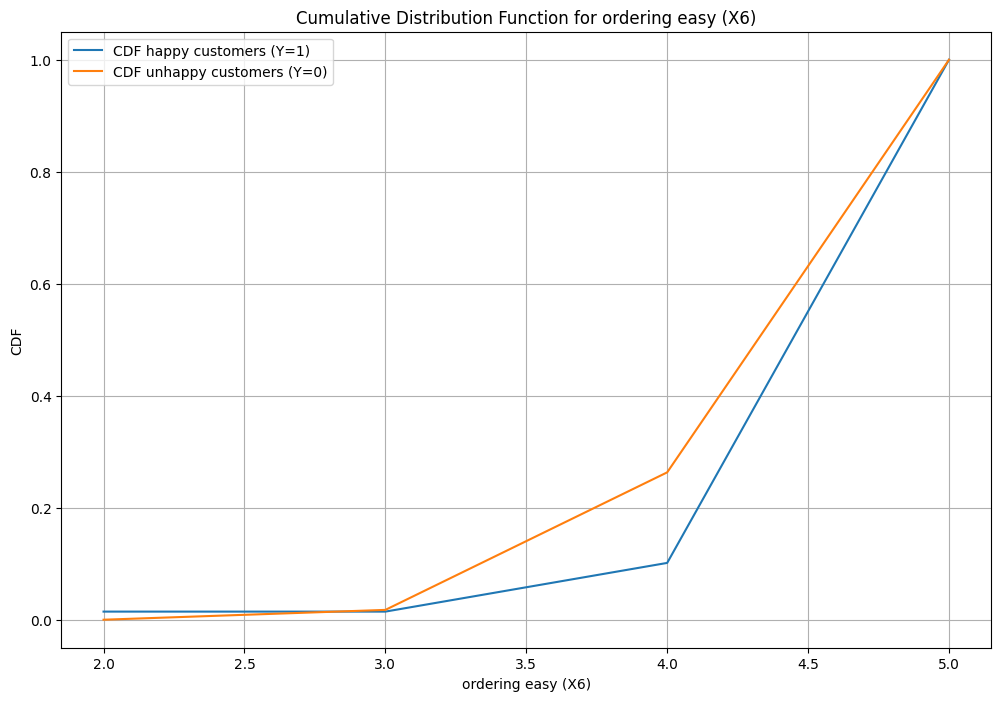

In [ ]:
# Let's update the bins and ensure they cover the range of X6 values from 1 to 5
bins = range(1, 6)  # Bins from 1 to 5 inclusive

# Calculate CDF for Y = 1 (happy)
counts_happy, bin_edges_happy = np.histogram(data[data['Y'] == 1]['X6'], bins=bins, density=True)
pdf_happy = counts_happy / sum(counts_happy)
cdf_happy = np.cumsum(pdf_happy)

# Calculate CDF for Y = 0 (unhappy)
counts_unhappy, bin_edges_unhappy = np.histogram(data[data['Y'] == 0]['X6'], bins=bins, density=True)
pdf_unhappy = counts_unhappy / sum(counts_unhappy)
cdf_unhappy = np.cumsum(pdf_unhappy)

# Plot the CDFs
plt.figure(figsize=(12, 8))

plt.plot(bin_edges_happy[1:], cdf_happy, label='CDF happy customers (Y=1)')
plt.plot(bin_edges_unhappy[1:], cdf_unhappy, label='CDF unhappy customers (Y=0)')

plt.legend()
plt.xlabel("ordering easy (X6)")
plt.ylabel("CDF")
plt.title('Cumulative Distribution Function for ordering easy (X6)')
plt.grid()
plt.show()

#customers with 4 or fewer X6 have about a chance of being unhappy.

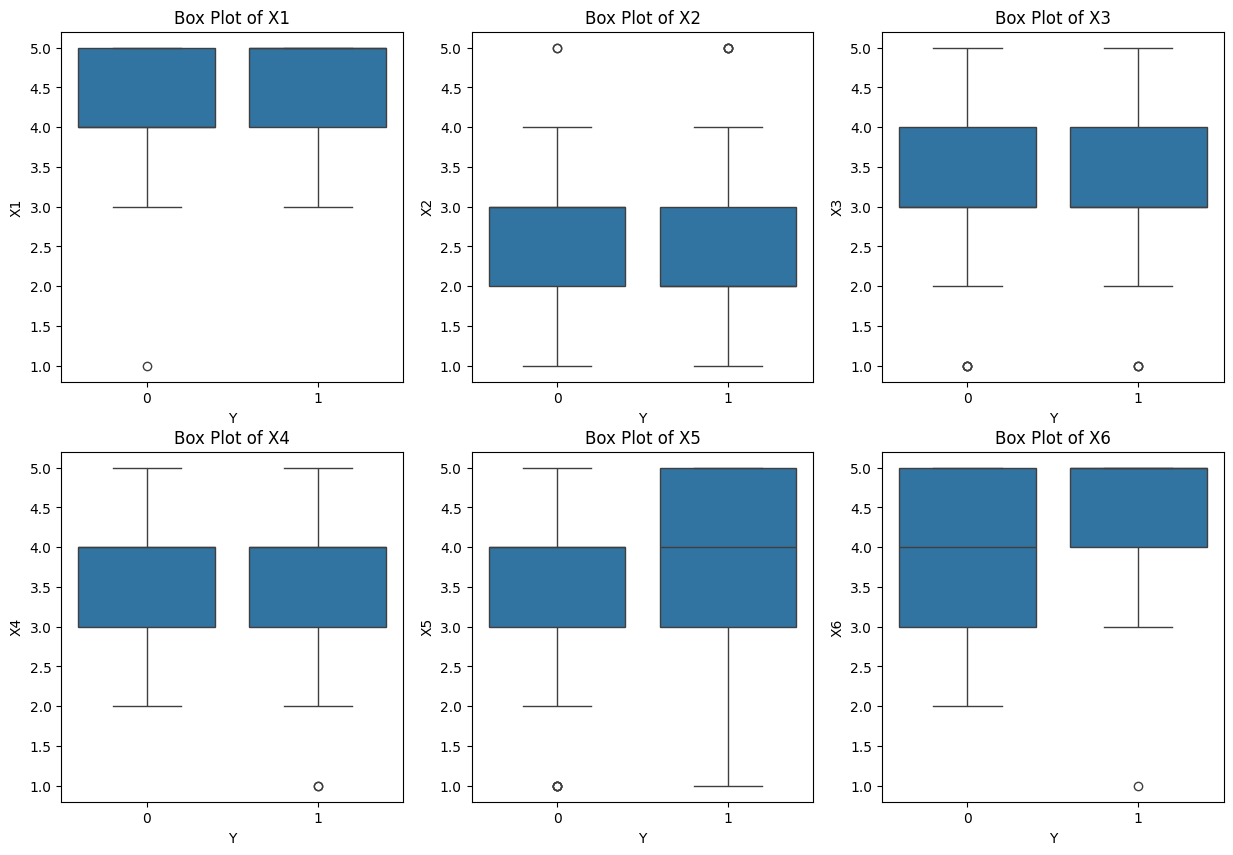

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
sns.boxplot(x='Y', y='X1', data=data)
plt.title('Box Plot of X1')
plt.subplot(2, 3, 2)
sns.boxplot(x='Y', y='X2', data=data)
plt.title('Box Plot of X2')
plt.subplot(2, 3, 3)
sns.boxplot(x='Y', y='X3', data=data)
plt.title('Box Plot of X3')
plt.subplot(2, 3, 4)
sns.boxplot(x='Y', y='X4', data=data)
plt.title('Box Plot of X4')
plt.subplot(2, 3, 5)
sns.boxplot(x='Y', y='X5', data=data)
plt.title('Box Plot of X5')
plt.subplot(2, 3, 6)
sns.boxplot(x='Y', y='X6', data=data)
plt.title('Box Plot of X6')
plt.show()
#X1 to X4 show similar statistic
#circles show outliers

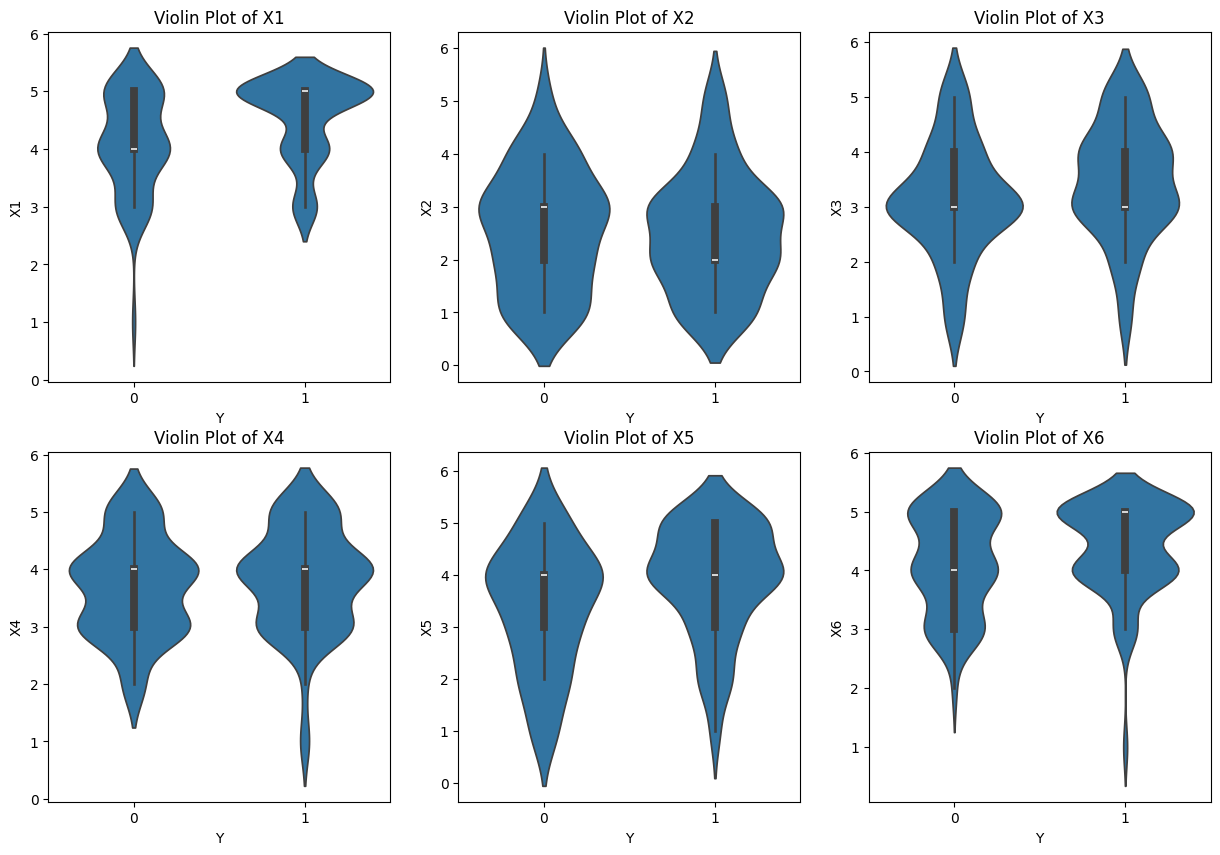

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
sns.violinplot(x='Y', y='X1', data=data)
plt.title('Violin Plot of X1')
plt.subplot(2, 3, 2)
sns.violinplot(x='Y', y='X2', data=data)
plt.title('Violin Plot of X2')
plt.subplot(2, 3, 3)
sns.violinplot(x='Y', y='X3', data=data)
plt.title('Violin Plot of X3')
plt.subplot(2, 3, 4)
sns.violinplot(x='Y', y='X4', data=data)
plt.title('Violin Plot of X4')
plt.subplot(2, 3, 5)
sns.violinplot(x='Y', y='X5', data=data)
plt.title('Violin Plot of X5')
plt.subplot(2, 3, 6)
sns.violinplot(x='Y', y='X6', data=data)
plt.title('Violin Plot of X6')
plt.show()
#X2 to X5 show similar statistic
#The distribution of X1 is highly skewed for the 1 class label and moderately skewed for the 0 label.

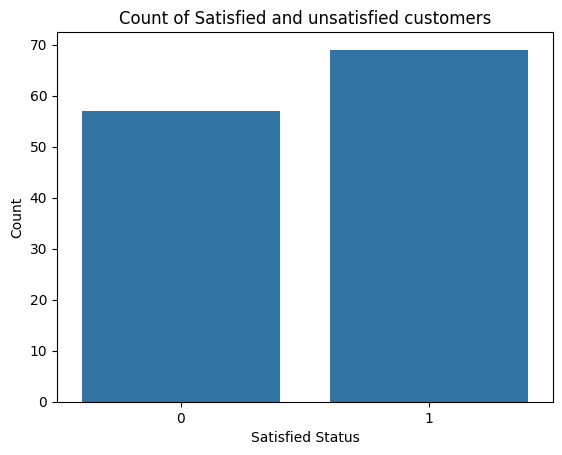

In [ ]:
sns.countplot(x='Y', data=df)
plt.title('Count of Satisfied and unsatisfied customers')
plt.xlabel('Satisfied Status')
plt.ylabel('Count')
plt.show()

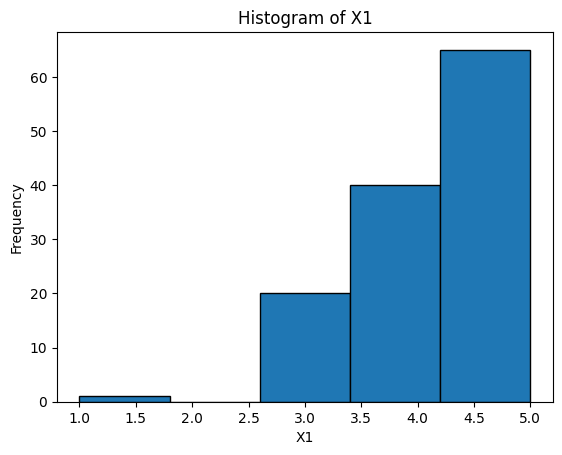

In [ ]:
df['X1'].plot(kind='hist', bins=5, edgecolor='black')
plt.title('Histogram of X1')
plt.xlabel('X1')
plt.ylabel('Frequency')
plt.show()

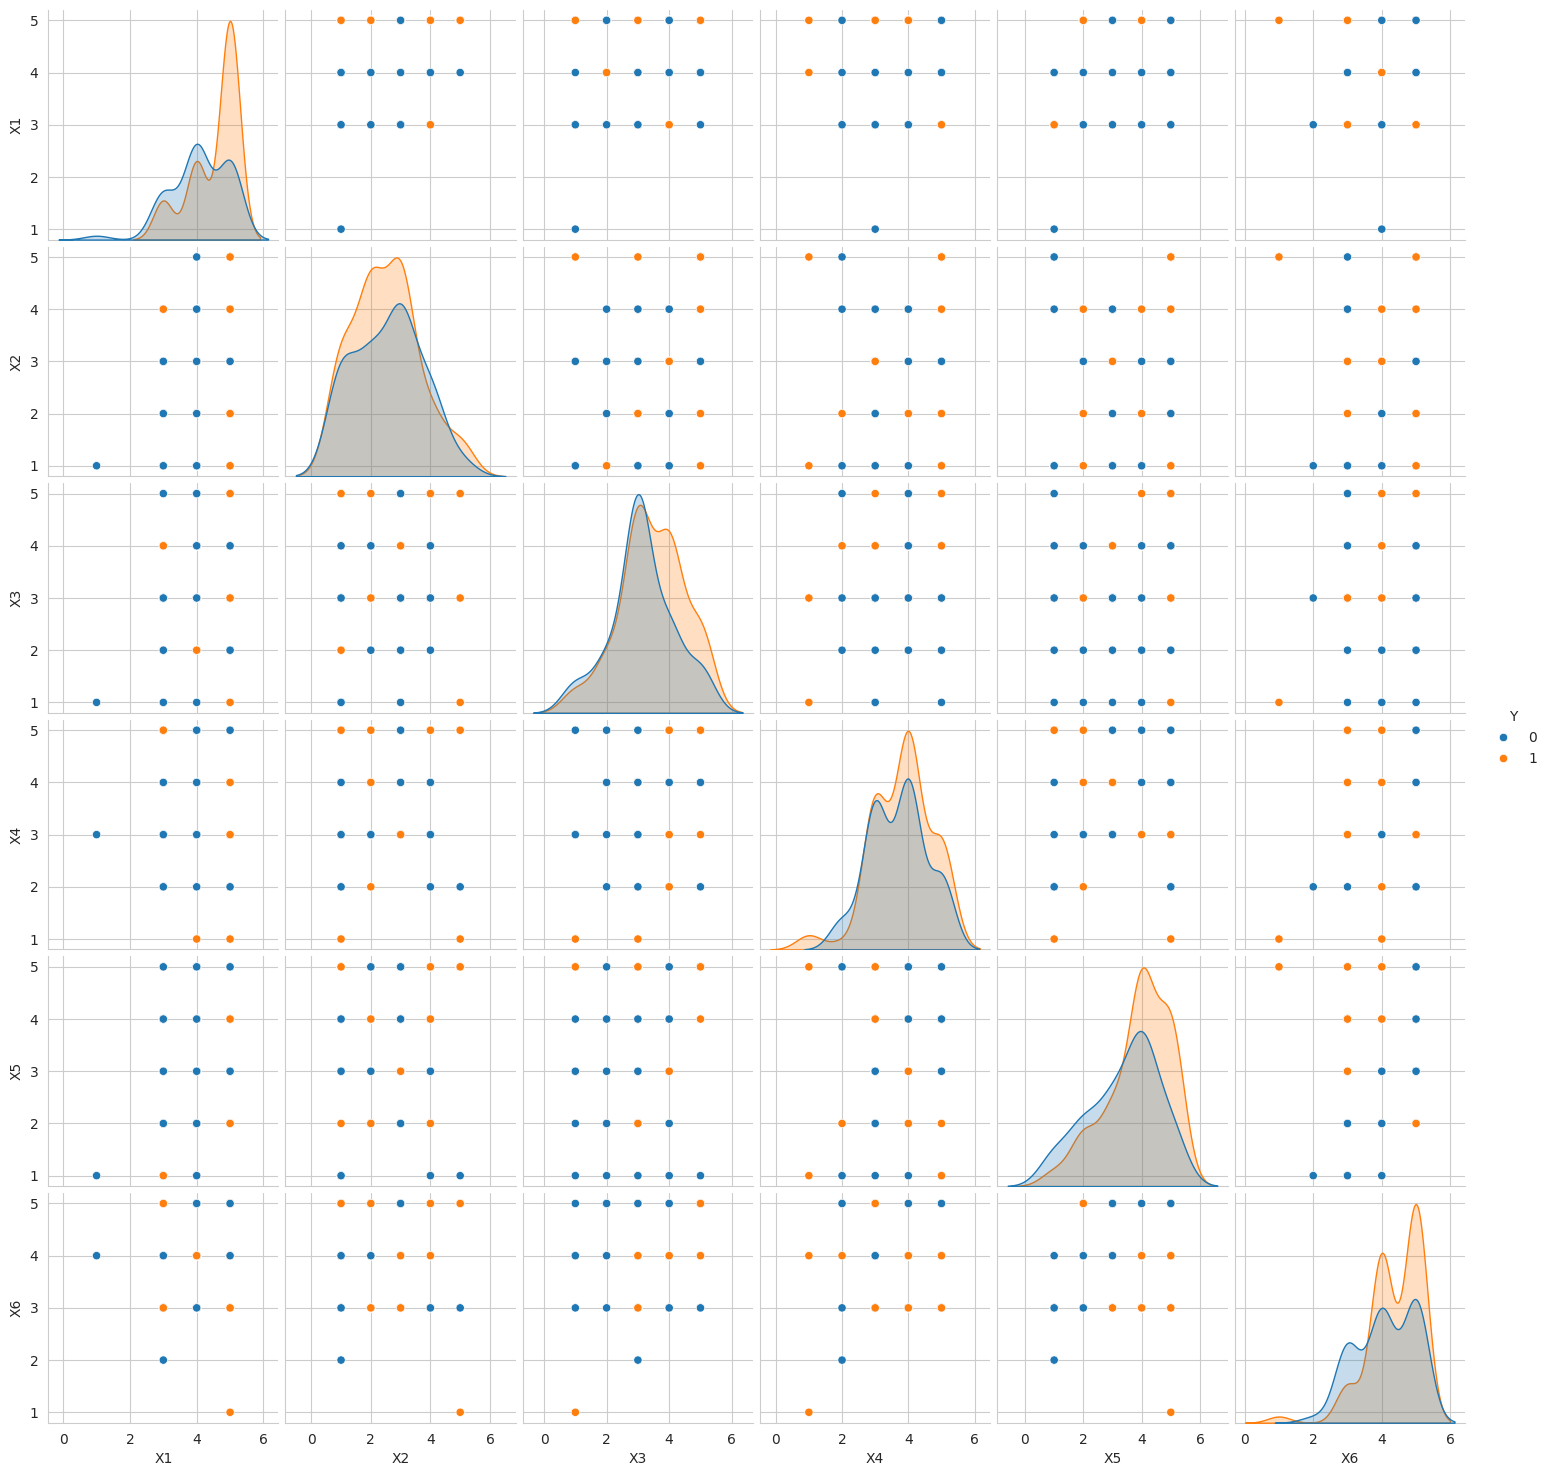

In [ ]:
sns.set_style('whitegrid')
sns.pairplot(data, hue='Y')
plt.show()
#There is a high overlap between any two features, indicating no clear distinction between the survival status class labels based on feature pairs.

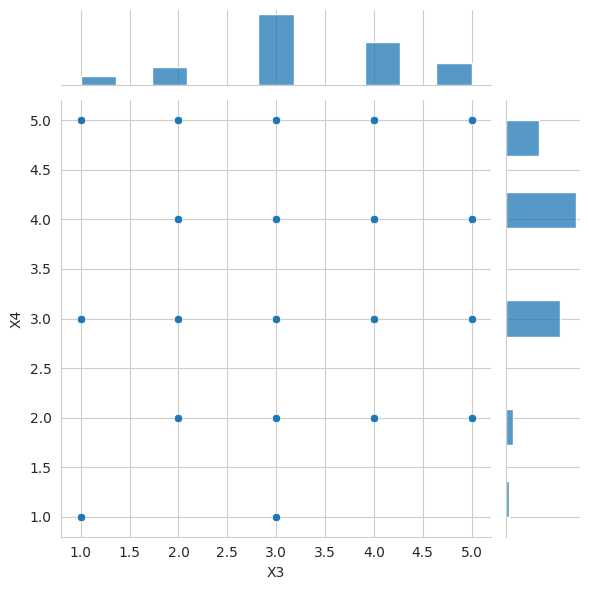

In [ ]:
sns.jointplot(x='X3', y='X4', data=data, kind='scatter')
plt.show()
#The scatter plot in the center shows no correlation between theX3 and X4.

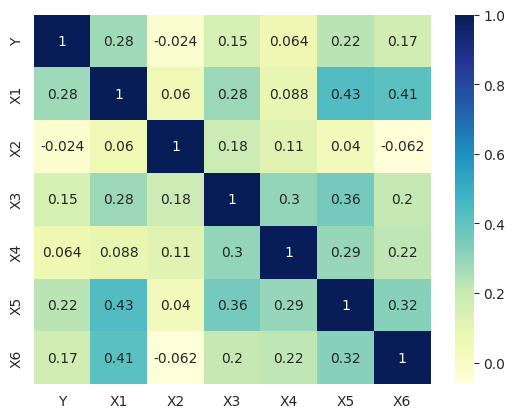

In [ ]:
sns.heatmap(data.corr(), cmap='YlGnBu', annot=True)
plt.show()
#There is a light correlation between X1 and X5,X6.
# Y is completely indpendent from X2 and X4.

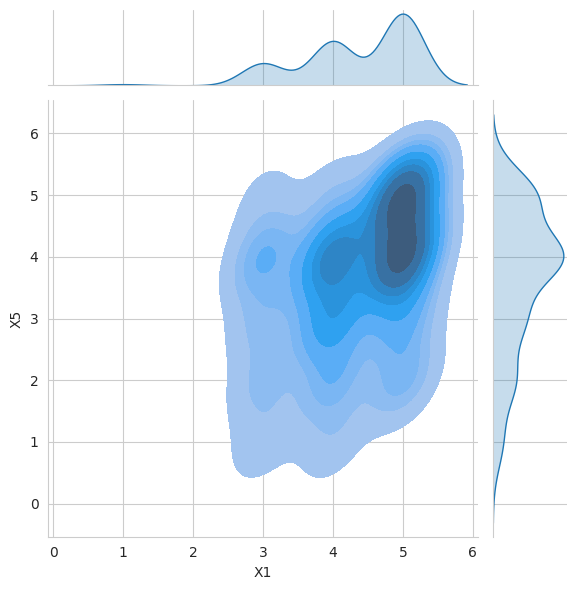

In [ ]:
sns.jointplot(x='X1', y='X5', data=data, kind='kde', fill=True)
plt.show()
#This shows most of the people rank 5 for both X1 and X5

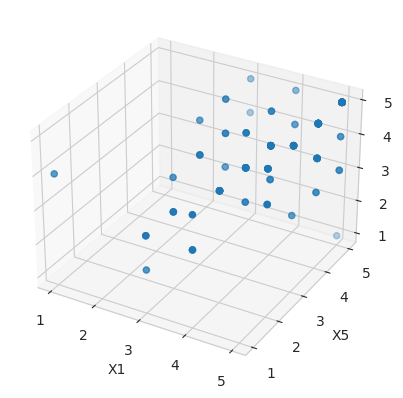

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['X1'], df['X5'], df['X6'])
ax.set_xlabel('X1')
ax.set_ylabel('X5')
ax.set_zlabel('X6')

plt.show()
#It shows most of the customers ranked 5 for X5.

In [ ]:
import random
seed=random.randint(1000,9999)
print(seed)

7548


In [ ]:
# Split the data into features and target variable
data = pd.read_csv('ACME-HappinessSurvey2020.csv', header = 0)
X = data.drop(columns=['Y'])
y = data['Y']

seed=7548
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
# Lets see the best model using lazypredict
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:01<00:00, 28.41it/s]

[LightGBM] [Info] Number of positive: 54, number of negative: 46
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540000 -> initscore=0.160343
[LightGBM] [Info] Start training from score 0.160343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BernoulliNB,0.73,0.75,0.75,0.73,0.02
ExtraTreesClassifier,0.73,0.74,0.74,0.73,0.14
RandomForestClassifier,0.73,0.74,0.74,0.73,0.16
Perceptron,0.73,0.73,0.73,0.73,0.02
NearestCentroid,0.69,0.72,0.72,0.69,0.02
BaggingClassifier,0.69,0.71,0.71,0.69,0.04
PassiveAggressiveClassifier,0.65,0.70,0.70,0.63,0.02
GaussianNB,0.65,0.69,0.69,0.64,0.02
CalibratedClassifierCV,0.65,0.68,0.68,0.65,0.04


In [ ]:
# Lets select top 5 algorithm based on accuracy.
best_models=models.sort_values(by=['Accuracy'], ascending=False).index.tolist()
list_models=best_models[:5]
list_models

['BernoulliNB',
 'RandomForestClassifier',
 'Perceptron',
 'ExtraTreesClassifier',
 'NearestCentroid']

In [ ]:
#Lets use Hyperopt to find best parameters for XGBClassifier.
# Define the objective function
def objective(params):
    clf = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=seed
    )

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = np.mean(preds == y_test)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-3), np.log(10)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-3), np.log(10))
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best parameters
print("Best parameters:", best)

# Train the model with the best parameters
best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'gamma': best['gamma'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

model = XGBClassifier(**best_params)
model.fit(X_train, y_train)

# Predict and print classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

100%|██████████| 50/50 [00:03<00:00, 14.19trial/s, best loss: -0.7692307692307693]
Best parameters: {'colsample_bytree': 0.896672497979143, 'gamma': 0.15710978115653051, 'learning_rate': 0.1984083916292992, 'max_depth': 9.0, 'n_estimators': 80.0, 'reg_alpha': 0.005000896487967903, 'reg_lambda': 0.6130869437772835, 'subsample': 0.6533140642505966}
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        14
           1       0.64      0.58      0.61        12

    accuracy                           0.65        26
   macro avg       0.65      0.65      0.65        26
weighted avg       0.65      0.65      0.65        26

Confusion Matrix:
 [[10  4]
 [ 5  7]]


In [ ]:
#ExtraTreeClassifier
# Define the objective function
def objective(params):
    clf = ExtraTreesClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']) if params['max_depth'] is not None else None,
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        max_features=params['max_features'],
        random_state=seed
    )

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = np.mean(preds == y_test)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None])
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best parameters
print("Best parameters:", best)

# Train the model with the best parameters
best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']) if best['max_depth'] is not None else None,
    'min_samples_split': int(best['min_samples_split']),
    'min_samples_leaf': int(best['min_samples_leaf']),
    'max_features': best['max_features']
}

model = ExtraTreesClassifier(**best_params, random_state=seed)
model.fit(X_train, y_train)

# Predict and print classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


100%|██████████| 50/50 [00:27<00:00,  1.85trial/s, best loss: -0.7692307692307693]
Best parameters: {'max_depth': 4.0, 'max_features': 2, 'min_samples_leaf': 3.0, 'min_samples_split': 5.0, 'n_estimators': 230.0}
              precision    recall  f1-score   support

           0       0.88      0.50      0.64        14
           1       0.61      0.92      0.73        12

    accuracy                           0.69        26
   macro avg       0.74      0.71      0.68        26
weighted avg       0.75      0.69      0.68        26

Confusion Matrix:
 [[ 7  7]
 [ 1 11]]


In [ ]:
#RandomForestClassifier
# Define the objective function
def objective(params):
    clf = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']) if params['max_depth'] is not None else None,
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        max_features=params['max_features'],
        random_state=seed
    )

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = np.mean(preds == y_test)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None])
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best parameters
print("Best parameters:", best)

# Train the model with the best parameters
best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']) if best['max_depth'] is not None else None,
    'min_samples_split': int(best['min_samples_split']),
    'min_samples_leaf': int(best['min_samples_leaf']),
    'max_features': best['max_features']
}

model = RandomForestClassifier(**best_params, random_state=seed)
model.fit(X_train, y_train)

# Predict and print classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

100%|██████████| 50/50 [00:17<00:00,  2.85trial/s, best loss: -0.7307692307692307]
Best parameters: {'max_depth': 5.0, 'max_features': 2, 'min_samples_leaf': 3.0, 'min_samples_split': 6.0, 'n_estimators': 140.0}
              precision    recall  f1-score   support

           0       0.88      0.50      0.64        14
           1       0.61      0.92      0.73        12

    accuracy                           0.69        26
   macro avg       0.74      0.71      0.68        26
weighted avg       0.75      0.69      0.68        26

Confusion Matrix:
 [[ 7  7]
 [ 1 11]]


In [ ]:
#QuadraticDiscriminantAnalysis
# Define the objective function
def objective(params):
    clf = QuadraticDiscriminantAnalysis(
        reg_param=params['reg_param'],
        tol=params['tol'],
        store_covariance=params['store_covariance']
    )

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = np.mean(preds == y_test)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'reg_param': hp.uniform('reg_param', 0.0, 1.0),
    'tol': hp.loguniform('tol', np.log(1e-5), np.log(1e-1)),
    'store_covariance': hp.choice('store_covariance', [True, False])
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best parameters
print("Best parameters:", best)

# Convert categorical parameters back
best['store_covariance'] = [True, False][best['store_covariance']]

# Train the model with the best parameters
best_params = {
    'reg_param': best['reg_param'],
    'tol': best['tol'],
    'store_covariance': best['store_covariance']
}

model = QuadraticDiscriminantAnalysis(**best_params)
model.fit(X_train, y_train)

# Predict and print classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

100%|██████████| 50/50 [00:00<00:00, 57.42trial/s, best loss: -0.7692307692307693]
Best parameters: {'reg_param': 0.5427867175413547, 'store_covariance': 0, 'tol': 0.08037850039485717}
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        14
           1       0.75      0.75      0.75        12

    accuracy                           0.77        26
   macro avg       0.77      0.77      0.77        26
weighted avg       0.77      0.77      0.77        26

Confusion Matrix:
 [[11  3]
 [ 3  9]]


In [ ]:
#LabelPropagation
# Define the objective function
def objective(params):
    clf = LabelPropagation(
        kernel=params['kernel'],
        gamma=params['gamma'],
        n_neighbors=int(params['n_neighbors']),
        max_iter=int(params['max_iter'])
    )

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = np.mean(preds == y_test)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'kernel': hp.choice('kernel', ['knn', 'rbf']),
    'gamma': hp.loguniform('gamma', np.log(1e-4), np.log(1e-1)),
    'n_neighbors': hp.quniform('n_neighbors', 2, 50, 1),
    'max_iter': hp.quniform('max_iter', 100, 1000, 50)
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best parameters
print("Best parameters:", best)

# Convert categorical parameters back
best['kernel'] = ['knn', 'rbf'][best['kernel']]

# Train the model with the best parameters
best_params = {
    'kernel': best['kernel'],
    'gamma': best['gamma'],
    'n_neighbors': int(best['n_neighbors']),
    'max_iter': int(best['max_iter'])
}

model = LabelPropagation(**best_params)
model.fit(X_train, y_train)

# Predict and print classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

100%|██████████| 50/50 [00:01<00:00, 29.63trial/s, best loss: -0.7307692307692307]
Best parameters: {'gamma': 0.006045115636051955, 'kernel': 0, 'max_iter': 950.0, 'n_neighbors': 44.0}
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        14
           1       0.63      1.00      0.77        12

    accuracy                           0.73        26
   macro avg       0.82      0.75      0.72        26
weighted avg       0.83      0.73      0.72        26

Confusion Matrix:
 [[ 7  7]
 [ 0 12]]


In [ ]:
# LabelSpreading

# Define the objective function
def objective(params):
    clf = LabelSpreading(
        kernel=params['kernel'],
        gamma=params['gamma'],
        alpha=params['alpha'],
        max_iter=int(params['max_iter'])
    )

    # Fit the model (Note: LabelSpreading expects some unlabeled data, typically marked as -1)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = np.mean(preds == y_test)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'kernel': hp.choice('kernel', ['knn', 'rbf']),
    'gamma': hp.loguniform('gamma', np.log(1e-3), np.log(1)),
    'alpha': hp.uniform('alpha', 0.1, 1.0),
    'max_iter': hp.quniform('max_iter', 100, 1000, 50)
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best parameters
print("Best parameters:", best)

# Map the best parameters back from hyperopt format
best_params = {
    'kernel': ['knn', 'rbf'][best['kernel']],
    'gamma': best['gamma'],
    'alpha': best['alpha'],
    'max_iter': int(best['max_iter'])
}

# Train the model with the best parameters
model = LabelSpreading(**best_params)
model.fit(X_train, y_train)

# Predict and print classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


100%|██████████| 50/50 [00:01<00:00, 30.18trial/s, best loss: -0.7307692307692307]
Best parameters: {'alpha': 0.2875751894158633, 'gamma': 0.5829624357612684, 'kernel': 1, 'max_iter': 700.0}
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        14
           1       0.63      1.00      0.77        12

    accuracy                           0.73        26
   macro avg       0.82      0.75      0.72        26
weighted avg       0.83      0.73      0.72        26

Confusion Matrix:
 [[ 7  7]
 [ 0 12]]


In [ ]:
#KNeighborsClassifier
# Define the objective function
def objective(params):
    clf = KNeighborsClassifier(
        n_neighbors=int(params['n_neighbors']),
        weights=params['weights'],
        algorithm=params['algorithm'],
        leaf_size=int(params['leaf_size']),
        p=int(params['p'])
    )

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = np.mean(preds == y_test)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'n_neighbors': hp.quniform('n_neighbors', 1, 30, 1),
    'weights': hp.choice('weights', ['uniform', 'distance']),
    'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
    'leaf_size': hp.quniform('leaf_size', 20, 50, 1),
    'p': hp.quniform('p', 1, 2, 1)
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best parameters
print("Best parameters:", best)

# Map the best parameters back from hyperopt format
best_params = {
    'n_neighbors': int(best['n_neighbors']),
    'weights': ['uniform', 'distance'][best['weights']],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'][best['algorithm']],
    'leaf_size': int(best['leaf_size']),
    'p': int(best['p'])
}

# Train the model with the best parameters
model = KNeighborsClassifier(**best_params)
model.fit(X_train, y_train)

# Predict and print classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


100%|██████████| 50/50 [00:01<00:00, 36.32trial/s, best loss: -0.7307692307692307]
Best parameters: {'algorithm': 0, 'leaf_size': 38.0, 'n_neighbors': 2.0, 'p': 2.0, 'weights': 1}
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        14
           1       0.69      0.75      0.72        12

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26

Confusion Matrix:
 [[10  4]
 [ 3  9]]


In [ ]:
#BernouliNB

# Define the objective function
def objective(params):
    clf = BernoulliNB(
        alpha=params['alpha'],
        binarize=params['binarize'],
        fit_prior=params['fit_prior']
    )

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = np.mean(preds == y_test)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'alpha': hp.loguniform('alpha', np.log(1e-3), np.log(10)),
    'binarize': hp.uniform('binarize', 0, 1),
    'fit_prior': hp.choice('fit_prior', [True, False])
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best parameters
print("Best parameters:", best)

# Map the best parameters back from hyperopt format
best_params = {
    'alpha': best['alpha'],
    'binarize': best['binarize'],
    'fit_prior': [True, False][best['fit_prior']]
}

# Train the model with the best parameters
model = BernoulliNB(**best_params)
model.fit(X_train, y_train)

# Predict and print classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


100%|██████████| 50/50 [00:00<00:00, 67.93trial/s, best loss: -0.5769230769230769]
Best parameters: {'alpha': 0.0539362302761136, 'binarize': 0.9409821376091352, 'fit_prior': 0}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.58      1.00      0.73        15

    accuracy                           0.58        26
   macro avg       0.29      0.50      0.37        26
weighted avg       0.33      0.58      0.42        26

Confusion Matrix:
 [[ 0 11]
 [ 0 15]]


In [ ]:
#Perceptron
# Define the objective function
def objective(params):
    clf = Perceptron(
        penalty=params['penalty'],
        alpha=params['alpha'],
        max_iter=int(params['max_iter']),
        tol=params['tol'],
        fit_intercept=params['fit_intercept']
    )

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = np.mean(preds == y_test)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'penalty': hp.choice('penalty', ['l2', 'l1', 'elasticnet', None]),
    'alpha': hp.loguniform('alpha', np.log(1e-5), np.log(1e-1)),
    'max_iter': hp.quniform('max_iter', 50, 500, 10),
    'tol': hp.loguniform('tol', np.log(1e-5), np.log(1e-1)),
    'fit_intercept': hp.choice('fit_intercept', [True, False])
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best parameters
print("Best parameters:", best)

# Map the best parameters back from hyperopt format
best_params = {
    'penalty': ['l2', 'l1', 'elasticnet', None][best['penalty']],
    'alpha': best['alpha'],
    'max_iter': int(best['max_iter']),
    'tol': best['tol'],
    'fit_intercept': [True, False][best['fit_intercept']]
}

# Train the model with the best parameters
model = Perceptron(**best_params)
model.fit(X_train, y_train)

# Predict and print classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


100%|██████████| 50/50 [00:01<00:00, 30.13trial/s, best loss: -0.6923076923076923]
Best parameters: {'alpha': 4.118193855557121e-05, 'fit_intercept': 1, 'max_iter': 150.0, 'penalty': 1, 'tol': 0.07031896239369803}
              precision    recall  f1-score   support

           0       0.60      0.82      0.69        11
           1       0.82      0.60      0.69        15

    accuracy                           0.69        26
   macro avg       0.71      0.71      0.69        26
weighted avg       0.73      0.69      0.69        26

Confusion Matrix:
 [[9 2]
 [6 9]]


In [ ]:
#NearestCentroid
# Define the objective function
def objective(params):
    clf = NearestCentroid(
        metric=params['metric'],
        shrink_threshold=params['shrink_threshold']
    )

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = np.mean(preds == y_test)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'metric': hp.choice('metric', ['euclidean', 'manhattan']),
    'shrink_threshold': hp.uniform('shrink_threshold', 0, 1)
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best parameters
print("Best parameters:", best)

# Map the best parameters back from hyperopt format
best_params = {
    'metric': ['euclidean', 'manhattan'][best['metric']],
    'shrink_threshold': best['shrink_threshold']
}

# Train the model with the best parameters
model = NearestCentroid(**best_params)
model.fit(X_train, y_train)

# Predict and print classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


100%|██████████| 50/50 [00:01<00:00, 33.12trial/s, best loss: -0.6923076923076923]
Best parameters: {'metric': 0, 'shrink_threshold': 0.2504858271803193}
              precision    recall  f1-score   support

           0       0.59      0.91      0.71        11
           1       0.89      0.53      0.67        15

    accuracy                           0.69        26
   macro avg       0.74      0.72      0.69        26
weighted avg       0.76      0.69      0.69        26

Confusion Matrix:
 [[10  1]
 [ 7  8]]


In [ ]:
#The best accuracy from the result above is for the QuadraticDiscriminantAnalysis Classifier with an accuracy = 77%.
#The recall is equal to 0.79 for class 0, which means that most unhappy customers were predicted with the right class (class 0).
#So, the company has more chance to handle with its unhappy customers and know what makes them unsatisfied.

In [ ]:
# Split the data into features and target variable
data = pd.read_csv('ACME-HappinessSurvey2020.csv', header = 0)
X = data.drop(columns=['Y'])
y = data['Y']

seed=7548
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
# lets use StackingClassifier to ensemble above algorithms with best parameters derived by hyperopt for each estimator.
estimators = [
    ('rf', RandomForestClassifier(max_depth=5, max_features= 2, min_samples_leaf=3, min_samples_split=6, n_estimators= 140)),
    ('extc', ExtraTreesClassifier(max_depth=4, max_features= 2, min_samples_leaf= 3, min_samples_split= 5, n_estimators= 230)),
    ('qda', QuadraticDiscriminantAnalysis(reg_param=0.5427867175413547, store_covariance=0, tol=0.08037850039485717)),
    ('lbs', LabelSpreading(alpha= 0.2875751894158633, gamma= 0.5829624357612684, kernel= 'rbf', max_iter= 700)),
    ('lbp', LabelPropagation(gamma= 0.006045115636051955, kernel= 'knn', max_iter= 950, n_neighbors= 44)),
    ('knc', KNeighborsClassifier(algorithm= 'auto', leaf_size= 38, n_neighbors= 2, p= 2, weights= 'distance')),
    ('prn', Perceptron(alpha= 4.118193855557121e-05, fit_intercept= 1, max_iter= 150, penalty= 'l1', tol= 0.07031896239369803)),
    ('ncd', NearestCentroid(metric= 'euclidean', shrink_threshold= 0.2504858271803193))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

clf.fit(X_train, y_train)

# Predict and print classification report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.62      0.73      0.67        11
           1       0.77      0.67      0.71        15

    accuracy                           0.69        26
   macro avg       0.69      0.70      0.69        26
weighted avg       0.70      0.69      0.69        26

Confusion Matrix:
 [[ 8  3]
 [ 5 10]]


In [ ]:
estimators = [
    ('rf', RandomForestClassifier()),
    ('extc', ExtraTreesClassifier()),
    ('qda', QuadraticDiscriminantAnalysis(reg_param=0.5427867175413547, store_covariance=0, tol=0.08037850039485717)),
    ('lbs', LabelSpreading(alpha= 0.2875751894158633, gamma= 0.5829624357612684, kernel= 'rbf', max_iter= 700)),
    ('lbp', LabelPropagation(gamma= 0.006045115636051955, kernel= 'knn', max_iter= 950, n_neighbors= 44)),
    ('knc', KNeighborsClassifier(algorithm= 'auto', leaf_size= 38, n_neighbors= 2, p= 2, weights= 'distance')),
    ('prn', Perceptron(alpha= 4.118193855557121e-05, fit_intercept= 1, max_iter= 150, penalty= 'l1', tol= 0.07031896239369803)),
    ('ncd', NearestCentroid(metric= 'euclidean', shrink_threshold= 0.2504858271803193))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

clf.fit(X_train, y_train)

# Predict and print classification report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.76      0.87      0.81        15

    accuracy                           0.77        26
   macro avg       0.77      0.75      0.76        26
weighted avg       0.77      0.77      0.76        26

Confusion Matrix:
 [[ 7  4]
 [ 2 13]]


In [ ]:
#Lets use hyperopt to optize parameters of our StackingClassifier ensemble model.

# Define the objective function
def objective(params):
    estimators = [
        ('rf', RandomForestClassifier(
            n_estimators=int(params['rf_n_estimators']),
            max_depth=int(params['rf_max_depth']),
            min_samples_split=int(params['rf_min_samples_split']),
            min_samples_leaf=int(params['rf_min_samples_leaf'])
        )),
        ('extc', ExtraTreesClassifier(
            n_estimators=int(params['extc_n_estimators']),
            max_depth=int(params['extc_max_depth']),
            min_samples_split=int(params['extc_min_samples_split']),
            min_samples_leaf=int(params['extc_min_samples_leaf'])
        )),
        ('qda', QuadraticDiscriminantAnalysis(
            reg_param=params['qda_reg_param'],
            tol=params['qda_tol']
        )),
        ('lbs', LabelSpreading(
            alpha=params['lbs_alpha'],
            gamma=params['lbs_gamma'],
            kernel=params['lbs_kernel'],
            max_iter=int(params['lbs_max_iter'])
        )),
        ('lbp', LabelPropagation(
            gamma=params['lbp_gamma'],
            kernel=params['lbp_kernel'],
            max_iter=int(params['lbp_max_iter']),
            n_neighbors=int(params['lbp_n_neighbors'])
        )),
        ('knc', KNeighborsClassifier(
            n_neighbors=int(params['knc_n_neighbors']),
            leaf_size=int(params['knc_leaf_size']),
            p=int(params['knc_p']),
            weights=params['knc_weights']
        )),
        ('prn', Perceptron(
            penalty=params['prn_penalty'],
            alpha=params['prn_alpha'],
            fit_intercept=params['prn_fit_intercept'],
            max_iter=int(params['prn_max_iter']),
            tol=params['prn_tol']
        )),
        ('ncd', NearestCentroid(
            metric=params['ncd_metric'],
            shrink_threshold=params['ncd_shrink_threshold']
        ))
    ]

    clf = StackingClassifier(
        estimators=estimators, final_estimator=LogisticRegression()
    )

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = np.mean(preds == y_test)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'rf_n_estimators': hp.quniform('rf_n_estimators', 50, 500, 10),
    'rf_max_depth': hp.quniform('rf_max_depth', 3, 15, 1),
    'rf_min_samples_split': hp.quniform('rf_min_samples_split', 2, 10, 1),
    'rf_min_samples_leaf': hp.quniform('rf_min_samples_leaf', 1, 10, 1),

    'extc_n_estimators': hp.quniform('extc_n_estimators', 50, 500, 10),
    'extc_max_depth': hp.quniform('extc_max_depth', 3, 15, 1),
    'extc_min_samples_split': hp.quniform('extc_min_samples_split', 2, 10, 1),
    'extc_min_samples_leaf': hp.quniform('extc_min_samples_leaf', 1, 10, 1),

    'qda_reg_param': hp.uniform('qda_reg_param', 0.0, 1.0),
    'qda_tol': hp.loguniform('qda_tol', np.log(1e-5), np.log(1e-1)),

    'lbs_alpha': hp.uniform('lbs_alpha', 0.1, 1.0),
    'lbs_gamma': hp.uniform('lbs_gamma', 0.1, 1.0),
    'lbs_kernel': hp.choice('lbs_kernel', ['knn', 'rbf']),
    'lbs_max_iter': hp.quniform('lbs_max_iter', 100, 1000, 50),

    'lbp_gamma': hp.uniform('lbp_gamma', 0.1, 1.0),
    'lbp_kernel': hp.choice('lbp_kernel', ['knn', 'rbf']),
    'lbp_max_iter': hp.quniform('lbp_max_iter', 100, 1000, 50),
    'lbp_n_neighbors': hp.quniform('lbp_n_neighbors', 1, 50, 1),

    'knc_n_neighbors': hp.quniform('knc_n_neighbors', 1, 30, 1),
    'knc_leaf_size': hp.quniform('knc_leaf_size', 20, 50, 1),
    'knc_p': hp.quniform('knc_p', 1, 2, 1),
    'knc_weights': hp.choice('knc_weights', ['uniform', 'distance']),

    'prn_penalty': hp.choice('prn_penalty', ['l2', 'l1', 'elasticnet']),
    'prn_alpha': hp.loguniform('prn_alpha', np.log(1e-5), np.log(1e-1)),
    'prn_fit_intercept': hp.choice('prn_fit_intercept', [True, False]),
    'prn_max_iter': hp.quniform('prn_max_iter', 50, 500, 10),
    'prn_tol': hp.loguniform('prn_tol', np.log(1e-5), np.log(1e-1)),

    'ncd_metric': hp.choice('ncd_metric', ['euclidean', 'manhattan']),
    'ncd_shrink_threshold': hp.uniform('ncd_shrink_threshold', 0.0, 1.0)
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best parameters
print("Best parameters:", best)

# Map the best parameters back from hyperopt format
best_params = {
    'rf_n_estimators': int(best['rf_n_estimators']),
    'rf_max_depth': int(best['rf_max_depth']),
    'rf_min_samples_split': int(best['rf_min_samples_split']),
    'rf_min_samples_leaf': int(best['rf_min_samples_leaf']),

    'extc_n_estimators': int(best['extc_n_estimators']),
    'extc_max_depth': int(best['extc_max_depth']),
    'extc_min_samples_split': int(best['extc_min_samples_split']),
    'extc_min_samples_leaf': int(best['extc_min_samples_leaf']),

    'qda_reg_param': best['qda_reg_param'],
    'qda_tol': best['qda_tol'],

    'lbs_alpha': best['lbs_alpha'],
    'lbs_gamma': best['lbs_gamma'],
    'lbs_kernel': ['knn', 'rbf'][best['lbs_kernel']],
    'lbs_max_iter': int(best['lbs_max_iter']),

    'lbp_gamma': best['lbp_gamma'],
    'lbp_kernel': ['knn', 'rbf'][best['lbp_kernel']],
    'lbp_max_iter': int(best['lbp_max_iter']),
    'lbp_n_neighbors': int(best['lbp_n_neighbors']),

    'knc_n_neighbors': int(best['knc_n_neighbors']),
    'knc_leaf_size': int(best['knc_leaf_size']),
    'knc_p': int(best['knc_p']),
    'knc_weights': ['uniform', 'distance'][best['knc_weights']],

    'prn_penalty': ['l2', 'l1', 'elasticnet'][best['prn_penalty']],
    'prn_alpha': best['prn_alpha'],
    'prn_fit_intercept': [True, False][best['prn_fit_intercept']],
    'prn_max_iter': int(best['prn_max_iter']),
    'prn_tol': best['prn_tol'],

    'ncd_metric': ['euclidean', 'manhattan'][best['ncd_metric']],
    'ncd_shrink_threshold': best['ncd_shrink_threshold']
}

# Recreate the estimators with the best hyperparameters
estimators = [
    ('rf', RandomForestClassifier(
        n_estimators=best_params['rf_n_estimators'],
        max_depth=best_params['rf_max_depth'],
        min_samples_split=best_params['rf_min_samples_split'],
        min_samples_leaf=best_params['rf_min_samples_leaf']
    )),
    ('extc', ExtraTreesClassifier(
        n_estimators=best_params['extc_n_estimators'],
        max_depth=best_params['extc_max_depth'],
        min_samples_split=best_params['extc_min_samples_split'],
        min_samples_leaf=best_params['extc_min_samples_leaf']
    )),
    ('qda', QuadraticDiscriminantAnalysis(
        reg_param=best_params['qda_reg_param'],
        tol=best_params['qda_tol']
    )),
    ('lbs', LabelSpreading(
        alpha=best_params['lbs_alpha'],
        gamma=best_params['lbs_gamma'],
        kernel=best_params['lbs_kernel'],
        max_iter=best_params['lbs_max_iter']
    )),
    ('lbp', LabelPropagation(
        gamma=best_params['lbp_gamma'],
        kernel=best_params['lbp_kernel'],
        max_iter=best_params['lbp_max_iter'],
        n_neighbors=best_params['lbp_n_neighbors']
    )),
    ('knc', KNeighborsClassifier(
        n_neighbors=best_params['knc_n_neighbors'],
        leaf_size=best_params['knc_leaf_size'],
        p=best_params['knc_p'],
        weights=best_params['knc_weights']
    )),
    ('prn', Perceptron(
        penalty=best_params['prn_penalty'],
        alpha=best_params['prn_alpha'],
        fit_intercept=best_params['prn_fit_intercept'],
        max_iter=best_params['prn_max_iter'],
        tol=best_params['prn_tol']
    )),
    ('ncd', NearestCentroid(
        metric=best_params['ncd_metric'],
        shrink_threshold=best_params['ncd_shrink_threshold']
    ))
]

clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

# Train the model with the best parameters
clf.fit(X_train, y_train)

# Predict and print classification report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


100%|██████████| 50/50 [03:37<00:00,  4.36s/trial, best loss: -0.7692307692307693]
Best parameters: {'extc_max_depth': 12.0, 'extc_min_samples_leaf': 7.0, 'extc_min_samples_split': 3.0, 'extc_n_estimators': 170.0, 'knc_leaf_size': 33.0, 'knc_n_neighbors': 29.0, 'knc_p': 1.0, 'knc_weights': 1, 'lbp_gamma': 0.22124334991002198, 'lbp_kernel': 1, 'lbp_max_iter': 350.0, 'lbp_n_neighbors': 49.0, 'lbs_alpha': 0.317738141785477, 'lbs_gamma': 0.5788370530320106, 'lbs_kernel': 0, 'lbs_max_iter': 600.0, 'ncd_metric': 1, 'ncd_shrink_threshold': 0.9689213950965403, 'prn_alpha': 6.687052924994888e-05, 'prn_fit_intercept': 0, 'prn_max_iter': 170.0, 'prn_penalty': 2, 'prn_tol': 0.0003313544536704623, 'qda_reg_param': 0.8561061435453962, 'qda_tol': 0.0027247093654227377, 'rf_max_depth': 7.0, 'rf_min_samples_leaf': 9.0, 'rf_min_samples_split': 7.0, 'rf_n_estimators': 150.0}
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.9

In [ ]:
# lets use VotingClassifier to ensemble above algorithms with best parameters derived with hyperopt previously.
from sklearn.ensemble import VotingClassifier
estimators = [
    ('rf', RandomForestClassifier(max_depth=5, max_features= 2, min_samples_leaf=3, min_samples_split=6, n_estimators= 140)),
    ('extc', ExtraTreesClassifier(max_depth=4, max_features= 2, min_samples_leaf= 3, min_samples_split= 5, n_estimators= 230)),
    ('qda', QuadraticDiscriminantAnalysis(reg_param=0.5427867175413547, store_covariance=0, tol=0.08037850039485717)),
    ('lbs', LabelSpreading(alpha= 0.2875751894158633, gamma= 0.5829624357612684, kernel= 'rbf', max_iter= 700)),
    ('lbp', LabelPropagation(gamma= 0.006045115636051955, kernel= 'knn', max_iter= 950, n_neighbors= 44)),
    ('knc', KNeighborsClassifier(algorithm= 'auto', leaf_size= 38, n_neighbors= 2, p= 2, weights= 'distance'))
]
eclf1 = VotingClassifier(
    estimators=estimators, voting='hard'
)

eclf1.fit(X_train, y_train)

# Predict and print classification report

y_pred = eclf1.predict(X_test)
print('Results of votingclassifier for hard vote:\n',classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

eclf2 = VotingClassifier(
    estimators=estimators, voting='soft'
)

eclf2.fit(X_train, y_train)

# Predict and print classification report

y_pred = eclf2.predict(X_test)
print('Results of votingclassifier for soft vote:\n',classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

Results of votingclassifier for hard vote:
               precision    recall  f1-score   support

           0       0.60      0.82      0.69        11
           1       0.82      0.60      0.69        15

    accuracy                           0.69        26
   macro avg       0.71      0.71      0.69        26
weighted avg       0.73      0.69      0.69        26

Confusion Matrix:
 [[9 2]
 [6 9]]
Results of votingclassifier for soft vote:
               precision    recall  f1-score   support

           0       0.57      0.73      0.64        11
           1       0.75      0.60      0.67        15

    accuracy                           0.65        26
   macro avg       0.66      0.66      0.65        26
weighted avg       0.67      0.65      0.66        26

Confusion Matrix:
 [[8 3]
 [6 9]]


In [ ]:
# lets use VotingClassifier to ensemble above algorithms without parameters.
from sklearn.ensemble import VotingClassifier
estimators = [
    ('rf', RandomForestClassifier()),
    ('extc', ExtraTreesClassifier()),
    ('qda', QuadraticDiscriminantAnalysis()),
    ('lbs', LabelSpreading()),
    ('lbp', LabelPropagation()),
    ('knc', KNeighborsClassifier())
]
eclf1 = VotingClassifier(
    estimators=estimators, voting='hard'
)

eclf1.fit(X_train, y_train)

# Predict and print classification report

y_pred = eclf1.predict(X_test)
print('Results of votingclassifier for hard vote:\n',classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

eclf2 = VotingClassifier(
    estimators=estimators, voting='soft'
)

eclf2.fit(X_train, y_train)

# Predict and print classification report

y_pred = eclf2.predict(X_test)
print('Results of votingclassifier for soft vote:\n',classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

Results of votingclassifier for hard vote:
               precision    recall  f1-score   support

           0       0.53      0.73      0.62        11
           1       0.73      0.53      0.62        15

    accuracy                           0.62        26
   macro avg       0.63      0.63      0.62        26
weighted avg       0.65      0.62      0.62        26

Confusion Matrix:
 [[8 3]
 [7 8]]
Results of votingclassifier for soft vote:
               precision    recall  f1-score   support

           0       0.57      0.73      0.64        11
           1       0.75      0.60      0.67        15

    accuracy                           0.65        26
   macro avg       0.66      0.66      0.65        26
weighted avg       0.67      0.65      0.66        26

Confusion Matrix:
 [[8 3]
 [6 9]]


In [ ]:
#Use hyperopt to find best parameters for VotingClassifirer

# Define the objective function
def objective(params):
    rf = RandomForestClassifier(
        n_estimators=int(params['rf_n_estimators']),
        max_depth=int(params['rf_max_depth']),
        min_samples_split=int(params['rf_min_samples_split']),
        min_samples_leaf=int(params['rf_min_samples_leaf']),
        max_features=params['rf_max_features']
    )
    extc = ExtraTreesClassifier(
        n_estimators=int(params['extc_n_estimators']),
        max_depth=int(params['extc_max_depth']),
        min_samples_split=int(params['extc_min_samples_split']),
        min_samples_leaf=int(params['extc_min_samples_leaf']),
        max_features=params['extc_max_features']
    )
    qda = QuadraticDiscriminantAnalysis(
        reg_param=params['qda_reg_param'],
        tol=params['qda_tol']
    )
    lbs = LabelSpreading(
        alpha=params['lbs_alpha'],
        gamma=params['lbs_gamma'],
        kernel=params['lbs_kernel'],
        max_iter=int(params['lbs_max_iter'])
    )
    lbp = LabelPropagation(
        gamma=params['lbp_gamma'],
        kernel=params['lbp_kernel'],
        max_iter=int(params['lbp_max_iter']),
        n_neighbors=int(params['lbp_n_neighbors'])
    )
    knc = KNeighborsClassifier(
        n_neighbors=int(params['knc_n_neighbors']),
        leaf_size=int(params['knc_leaf_size']),
        p=int(params['knc_p']),
        weights=params['knc_weights']
    )

    estimators = [
        ('rf', rf),
        ('extc', extc),
        ('qda', qda),
        ('lbs', lbs),
        ('lbp', lbp),
        ('knc', knc)
    ]

    eclf = VotingClassifier(estimators=estimators, voting='hard')
    eclf.fit(X_train, y_train)
    preds = eclf.predict(X_test)
    accuracy = np.mean(preds == y_test)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'rf_n_estimators': hp.quniform('rf_n_estimators', 50, 500, 10),
    'rf_max_depth': hp.quniform('rf_max_depth', 3, 15, 1),
    'rf_min_samples_split': hp.quniform('rf_min_samples_split', 2, 10, 1),
    'rf_min_samples_leaf': hp.quniform('rf_min_samples_leaf', 1, 10, 1),
    'rf_max_features': hp.choice('rf_max_features', ['sqrt', 'log2', None]),

    'extc_n_estimators': hp.quniform('extc_n_estimators', 50, 500, 10),
    'extc_max_depth': hp.quniform('extc_max_depth', 3, 15, 1),
    'extc_min_samples_split': hp.quniform('extc_min_samples_split', 2, 10, 1),
    'extc_min_samples_leaf': hp.quniform('extc_min_samples_leaf', 1, 10, 1),
    'extc_max_features': hp.choice('extc_max_features', ['sqrt', 'log2', None]),

    'qda_reg_param': hp.uniform('qda_reg_param', 0.0, 1.0),
    'qda_tol': hp.loguniform('qda_tol', np.log(1e-5), np.log(1e-1)),

    'lbs_alpha': hp.uniform('lbs_alpha', 0.1, 1.0),
    'lbs_gamma': hp.uniform('lbs_gamma', 0.1, 1.0),
    'lbs_kernel': hp.choice('lbs_kernel', ['knn', 'rbf']),
    'lbs_max_iter': hp.quniform('lbs_max_iter', 100, 1000, 50),

    'lbp_gamma': hp.uniform('lbp_gamma', 0.1, 1.0),
    'lbp_kernel': hp.choice('lbp_kernel', ['knn', 'rbf']),
    'lbp_max_iter': hp.quniform('lbp_max_iter', 100, 1000, 50),
    'lbp_n_neighbors': hp.quniform('lbp_n_neighbors', 1, 50, 1),

    'knc_n_neighbors': hp.quniform('knc_n_neighbors', 1, 30, 1),
    'knc_leaf_size': hp.quniform('knc_leaf_size', 20, 50, 1),
    'knc_p': hp.quniform('knc_p', 1, 2, 1),
    'knc_weights': hp.choice('knc_weights', ['uniform', 'distance'])
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best parameters
print("Best parameters:", best)

# Map the best parameters back from hyperopt format
best_params = {
    'rf_n_estimators': int(best['rf_n_estimators']),
    'rf_max_depth': int(best['rf_max_depth']),
    'rf_min_samples_split': int(best['rf_min_samples_split']),
    'rf_min_samples_leaf': int(best['rf_min_samples_leaf']),
    'rf_max_features': ['sqrt', 'log2', None][best['rf_max_features']],

    'extc_n_estimators': int(best['extc_n_estimators']),
    'extc_max_depth': int(best['extc_max_depth']),
    'extc_min_samples_split': int(best['extc_min_samples_split']),
    'extc_min_samples_leaf': int(best['extc_min_samples_leaf']),
    'extc_max_features': ['sqrt', 'log2', None][best['extc_max_features']],

    'qda_reg_param': best['qda_reg_param'],
    'qda_tol': best['qda_tol'],

    'lbs_alpha': best['lbs_alpha'],
    'lbs_gamma': best['lbs_gamma'],
    'lbs_kernel': ['knn', 'rbf'][best['lbs_kernel']],
    'lbs_max_iter': int(best['lbs_max_iter']),

    'lbp_gamma': best['lbp_gamma'],
    'lbp_kernel': ['knn', 'rbf'][best['lbp_kernel']],
    'lbp_max_iter': int(best['lbp_max_iter']),
    'lbp_n_neighbors': int(best['lbp_n_neighbors']),

    'knc_n_neighbors': int(best['knc_n_neighbors']),
    'knc_leaf_size': int(best['knc_leaf_size']),
    'knc_p': int(best['knc_p']),
    'knc_weights': ['uniform', 'distance'][best['knc_weights']]
}

# Recreate the estimators with the best hyperparameters
estimators = [
    ('rf', RandomForestClassifier(
        n_estimators=best_params['rf_n_estimators'],
        max_depth=best_params['rf_max_depth'],
        min_samples_split=best_params['rf_min_samples_split'],
        min_samples_leaf=best_params['rf_min_samples_leaf'],
        max_features=best_params['rf_max_features']
    )),
    ('extc', ExtraTreesClassifier(
        n_estimators=best_params['extc_n_estimators'],
        max_depth=best_params['extc_max_depth'],
        min_samples_split=best_params['extc_min_samples_split'],
        min_samples_leaf=best_params['extc_min_samples_leaf'],
        max_features=best_params['extc_max_features']
    )),
    ('qda', QuadraticDiscriminantAnalysis(
        reg_param=best_params['qda_reg_param'],
        tol=best_params['qda_tol']
    )),
    ('lbs', LabelSpreading(
        alpha=best_params['lbs_alpha'],
        gamma=best_params['lbs_gamma'],
        kernel=best_params['lbs_kernel'],
        max_iter=best_params['lbs_max_iter']
    )),
    ('lbp', LabelPropagation(
        gamma=best_params['lbp_gamma'],
        kernel=best_params['lbp_kernel'],
        max_iter=best_params['lbp_max_iter'],
        n_neighbors=best_params['lbp_n_neighbors']
    )),
    ('knc', KNeighborsClassifier(
        n_neighbors=best_params['knc_n_neighbors'],
        leaf_size=best_params['knc_leaf_size'],
        p=best_params['knc_p'],
        weights=best_params['knc_weights']
    ))
]

# Hard Voting Classifier
eclf1 = VotingClassifier(
    estimators=estimators, voting='hard'
)
eclf1.fit(X_train, y_train)

# Predict and print classification report for hard voting
y_pred = eclf1.predict(X_test)
print('Results of VotingClassifier for hard vote:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

# Soft Voting Classifier
eclf2 = VotingClassifier(
    estimators=estimators, voting='soft'
)
eclf2.fit(X_train, y_train)

# Predict and print classification report for soft voting
y_pred = eclf2.predict(X_test)
print('Results of VotingClassifier for soft vote:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


100%|██████████| 50/50 [00:43<00:00,  1.14trial/s, best loss: -0.7307692307692307]
Best parameters: {'extc_max_depth': 15.0, 'extc_max_features': 0, 'extc_min_samples_leaf': 3.0, 'extc_min_samples_split': 8.0, 'extc_n_estimators': 50.0, 'knc_leaf_size': 21.0, 'knc_n_neighbors': 19.0, 'knc_p': 2.0, 'knc_weights': 0, 'lbp_gamma': 0.8580996803816128, 'lbp_kernel': 1, 'lbp_max_iter': 100.0, 'lbp_n_neighbors': 8.0, 'lbs_alpha': 0.9775305914943727, 'lbs_gamma': 0.4773049992485649, 'lbs_kernel': 1, 'lbs_max_iter': 450.0, 'qda_reg_param': 0.737480377070168, 'qda_tol': 0.00033172080930689383, 'rf_max_depth': 9.0, 'rf_max_features': 1, 'rf_min_samples_leaf': 2.0, 'rf_min_samples_split': 5.0, 'rf_n_estimators': 230.0}
Results of VotingClassifier for hard vote:
               precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.83      0.67      0.74        15

    accuracy                           0.73        26
   macro avg       0.

In [ ]:
# Lets use RFE to do feature selection.

# Use ExtraTreesClassifier for RFE
rfe_estimator = ExtraTreesClassifier(max_depth=4, max_features= 2, min_samples_leaf= 3, min_samples_split= 5, n_estimators= 230)

# Create the RFE model and select 3 features
selector = RFE(rfe_estimator, n_features_to_select=3)
selector = selector.fit(X, y)

# Get the support mask (True for selected features)
support = selector.support_

# Get the selected features
selected_features = X.loc[:, support]

# Define the final estimator
final_estimator = QuadraticDiscriminantAnalysis(reg_param=0.5427867175413547, store_covariance=0, tol=0.08037850039485717)

# Train the final estimator on the selected features
final_estimator.fit(selected_features, y)

# Print the results
print("Selected Features (indices):", np.where(support)[0])
print("Selected Features (data):\n", selected_features)

# making predictions with the final model
# X_test is my test dataset
X_test_selected = X_test.loc[:, support]  # Apply the same feature selection to the test set
y_pred = final_estimator.predict(X_test_selected)
print('Results of selected feature:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


Selected Features (indices): [0 4 5]
Selected Features (data):
      X1  X5  X6
0     3   2   4
1     3   4   3
2     5   3   5
3     5   3   5
4     5   3   5
..   ..  ..  ..
121   5   4   3
122   5   2   5
123   5   4   5
124   4   4   5
125   5   5   5

[126 rows x 3 columns]
Results of selected feature:
               precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.91      0.67      0.77        15

    accuracy                           0.77        26
   macro avg       0.79      0.79      0.77        26
weighted avg       0.81      0.77      0.77        26

Confusion Matrix:
 [[10  1]
 [ 5 10]]


In [ ]:
# You can see no change in the accuracy and recall when we remove 3 features.

In [ ]:
"""
Conclusion:
The project involved developing a machine learning model to predict customer satisfaction for a company. The model utilized six features: whether the project was delivered on time, whether the content met expectations, whether the customer was able to order everything they wanted, price, courier service, and the user-friendliness of the app.

The first step in the project was to perform exploratory data analysis (EDA) to detect correlations between these features. Next, I used the lazypredict library to identify the best-fitting algorithms for the dataset. I then employed the Hyperopt library to optimize the parameters of the algorithms selected by lazypredict.

The Quadratic Discriminant Analysis (QDA) classifier yielded the highest accuracy at 77%. The recall for class 0 (unhappy customers) was 0.79, indicating that most unhappy customers were correctly identified. This insight allows the company to better address the concerns of dissatisfied customers and understand what causes their dissatisfaction.

To further improve the model, I used the StackingClassifier and VotingClassifier to ensemble the best-performing algorithms. I also employed the RFE (Recursive Feature Elimination) library for feature selection, which revealed that three features were not correlated with customer satisfaction. This finding suggests that the company can remove three questions from its questionnaire, allowing it to focus on the most relevant factors affecting customer satisfaction.
This reduction in data collection can significantly lower costs and improve the management of key parameters.
"""